# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante:Javiera Ahumada Moreno

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

## Subir datasets de dígitos (train)

In [2]:
from google.colab import files
uploaded = files.upload()  # 1_digits_train.txt
!ls

Saving 1_digits_train.txt to 1_digits_train.txt
1_digits_train.txt  sample_data


In [3]:
from google.colab import files
uploaded = files.upload()  # 1_digits_test.txt
!ls

Saving 1_digits_test.txt to 1_digits_test.txt
1_digits_test.txt  1_digits_train.txt  sample_data


## Leer dataset de dígitos

In [4]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [ ]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

In [ ]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

In [7]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [8]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-8-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-8-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-8-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [ ]:
df_train

## Crear modelo

In [108]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [109]:
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [110]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [111]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [112]:
#modelo entrenamiento
start = time.time()
best_val_loss = float('inf')

for epoch in range(250):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#calculo de perdida y precision de validacion
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_accuracy += torch.sum(torch.argmax(val_outputs, dim=1) == val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)
    val_accuracy /= len(dataloader_val.dataset)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f | Validation Accuracy: %.3f' % (
        epoch, train_loss, val_loss, val_accuracy))

    # Guardar el mejor modelo basado en la pérdida de validación
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)

print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))


Epoch 0: Training Loss: 2.219 | Validation Loss: 2.111 | Validation Accuracy: 0.308
Epoch 1: Training Loss: 2.037 | Validation Loss: 1.923 | Validation Accuracy: 0.517
Epoch 2: Training Loss: 1.838 | Validation Loss: 1.720 | Validation Accuracy: 0.590
Epoch 3: Training Loss: 1.626 | Validation Loss: 1.507 | Validation Accuracy: 0.640
Epoch 4: Training Loss: 1.425 | Validation Loss: 1.302 | Validation Accuracy: 0.670
Epoch 5: Training Loss: 1.239 | Validation Loss: 1.147 | Validation Accuracy: 0.726
Epoch 6: Training Loss: 1.077 | Validation Loss: 1.006 | Validation Accuracy: 0.781
Epoch 7: Training Loss: 0.937 | Validation Loss: 0.879 | Validation Accuracy: 0.821
Epoch 8: Training Loss: 0.813 | Validation Loss: 0.744 | Validation Accuracy: 0.846
Epoch 9: Training Loss: 0.710 | Validation Loss: 0.663 | Validation Accuracy: 0.864
Epoch 10: Training Loss: 0.621 | Validation Loss: 0.584 | Validation Accuracy: 0.885
Epoch 11: Training Loss: 0.547 | Validation Loss: 0.499 | Validation Accura

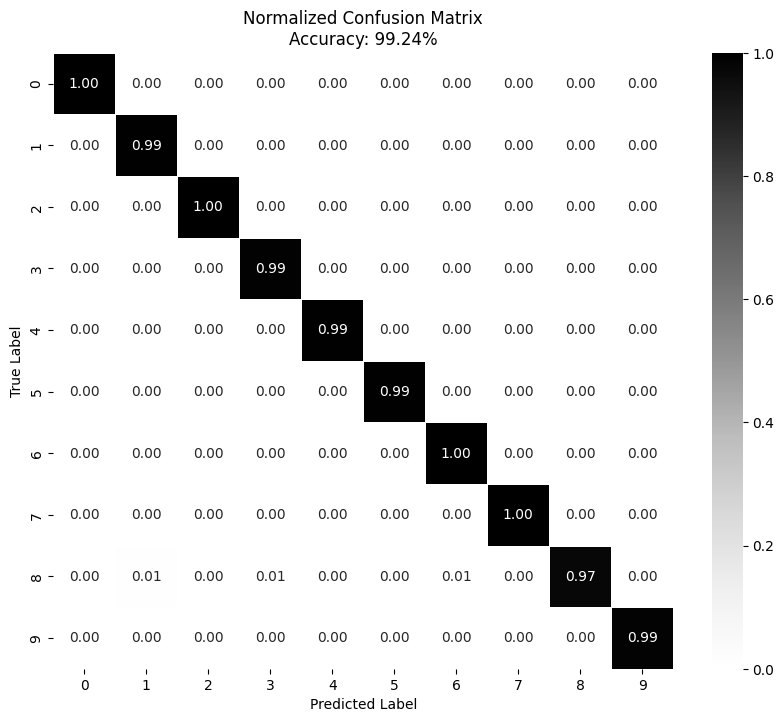

Accuracy Normalizado: 0.992


In [113]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

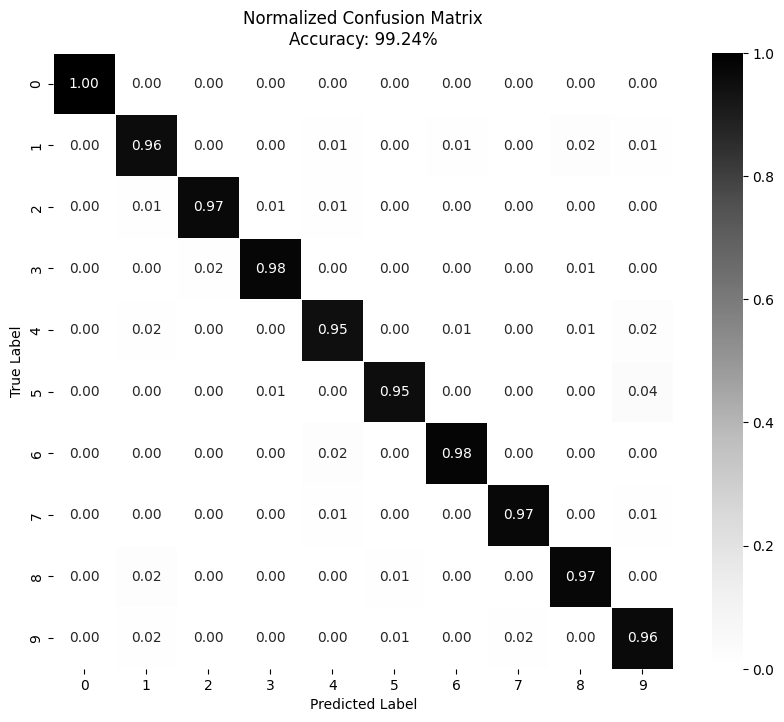

Accuracy Normalizado: 0.969


In [114]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

2) Entrenar una red neuronal para caso:

(a) 10 neuronas en la capa oculta, usando función de activación ReLU y 1000 epocas como máximo con su grafico


In [71]:
#  modelo con 10 neuronas en la capa oculta y ReLU 1000 epocas
model = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10))

device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 0: Training Loss: 2.184 | Validation Loss: 2.099
Epoch 1: Training Loss: 1.994 | Validation Loss: 1.907
Epoch 2: Training Loss: 1.794 | Validation Loss: 1.704
Epoch 3: Training Loss: 1.590 | Validation Loss: 1.506
Epoch 4: Training Loss: 1.392 | Validation Loss: 1.302
Epoch 5: Training Loss: 1.208 | Validation Loss: 1.140
Epoch 6: Training Loss: 1.041 | Validation Loss: 0.987
Epoch 7: Training Loss: 0.896 | Validation Loss: 0.850
Epoch 8: Training Loss: 0.775 | Validation Loss: 0.727
Epoch 9: Training Loss: 0.677 | Validation Loss: 0.635
Epoch 10: Training Loss: 0.598 | Validation Loss: 0.558
Epoch 11: Training Loss: 0.531 | Validation Loss: 0.490
Epoch 12: Training Loss: 0.476 | Validation Loss: 0.448
Epoch 13: Training Loss: 0.432 | Validation Loss: 0.419
Epoch 14: Training Loss: 0.393 | Validation Loss: 0.367
Epoch 15: Training Loss: 0.362 | Validation Loss: 0.355
Epoch 16: Training Loss: 0.334 | Validation Loss: 0.320
Epoch 17: Training Loss: 0.309 | Validation Loss: 0.300
Ep

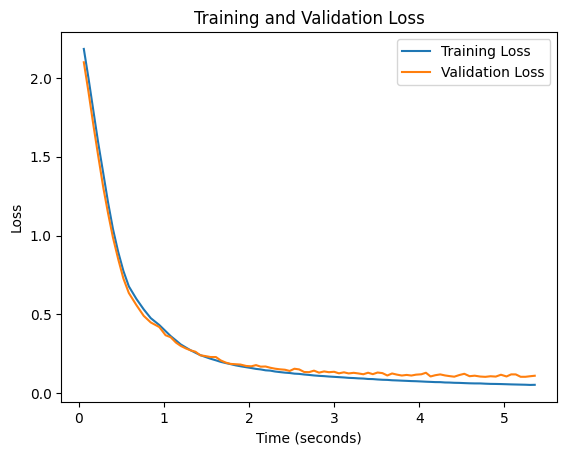

In [72]:
start = time.time()
#parametros
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 1000

train_losses = []
val_losses = []
times = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f' % (
        epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    times.append(time.time() - start)

    # Verificar si el loss de validación ha mejorado
    if val_loss < best_val_loss:

        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')

    else:
      epochs_no_improve += 1

      if epochs_no_improve == 10:
            print("Early stopping!")
            break

# Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)


print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))
end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Graficar curvas de loss de entrenamiento y validación
plt.plot(times, train_losses, label='Training Loss')
plt.plot(times, val_losses, label='Validation Loss')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

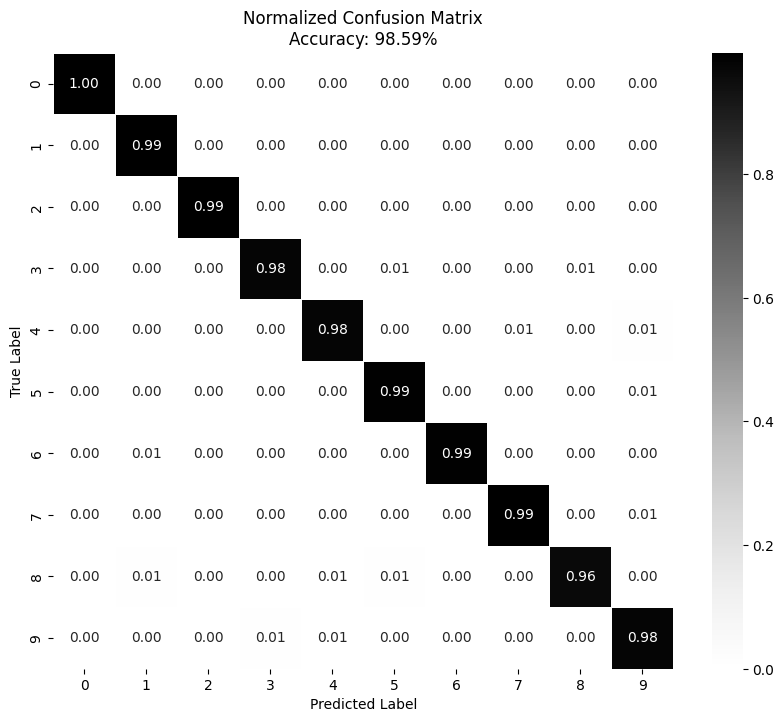

Accuracy Normalizado: 0.986


In [73]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

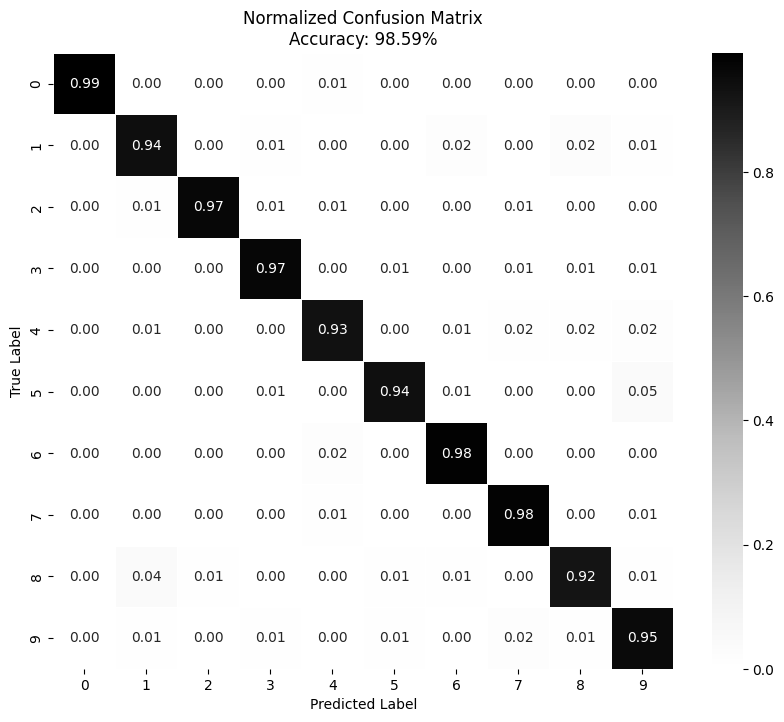

Accuracy Normalizado: 0.959


In [74]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

caso b):


In [75]:
#  modelo con 40 neuronas en la capa oculta y ReLU
model = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10))
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 0: Training Loss: 2.131 | Validation Loss: 1.932
Epoch 1: Training Loss: 1.725 | Validation Loss: 1.508
Epoch 2: Training Loss: 1.300 | Validation Loss: 1.094
Epoch 3: Training Loss: 0.923 | Validation Loss: 0.759
Epoch 4: Training Loss: 0.660 | Validation Loss: 0.566
Epoch 5: Training Loss: 0.494 | Validation Loss: 0.435
Epoch 6: Training Loss: 0.387 | Validation Loss: 0.369
Epoch 7: Training Loss: 0.318 | Validation Loss: 0.291
Epoch 8: Training Loss: 0.271 | Validation Loss: 0.254
Epoch 9: Training Loss: 0.236 | Validation Loss: 0.227
Epoch 10: Training Loss: 0.211 | Validation Loss: 0.230
Epoch 11: Training Loss: 0.188 | Validation Loss: 0.197
Epoch 12: Training Loss: 0.172 | Validation Loss: 0.177
Epoch 13: Training Loss: 0.157 | Validation Loss: 0.160
Epoch 14: Training Loss: 0.145 | Validation Loss: 0.154
Epoch 15: Training Loss: 0.134 | Validation Loss: 0.150
Epoch 16: Training Loss: 0.126 | Validation Loss: 0.140
Epoch 17: Training Loss: 0.118 | Validation Loss: 0.129
Ep

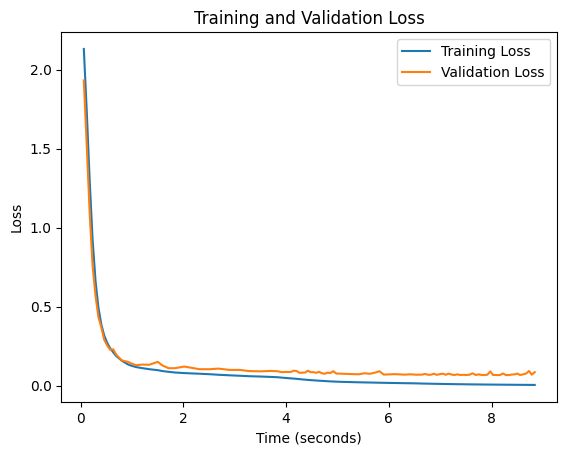

In [76]:
start = time.time()
#parametros
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 1000

train_losses = []
val_losses = []
times = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f' % (
        epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    times.append(time.time() - start)

    # Verificar si el loss de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        # Detener entrenamiento si el loss de validación no mejora durante 10 épocas consecutivas
        if epochs_no_improve == 10:
            print("Early stopping!")
            break

 # Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)

print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))
end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Graficar curvas de loss de entrenamiento y validación
plt.plot(times, train_losses, label='Training Loss')
plt.plot(times, val_losses, label='Validation Loss')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

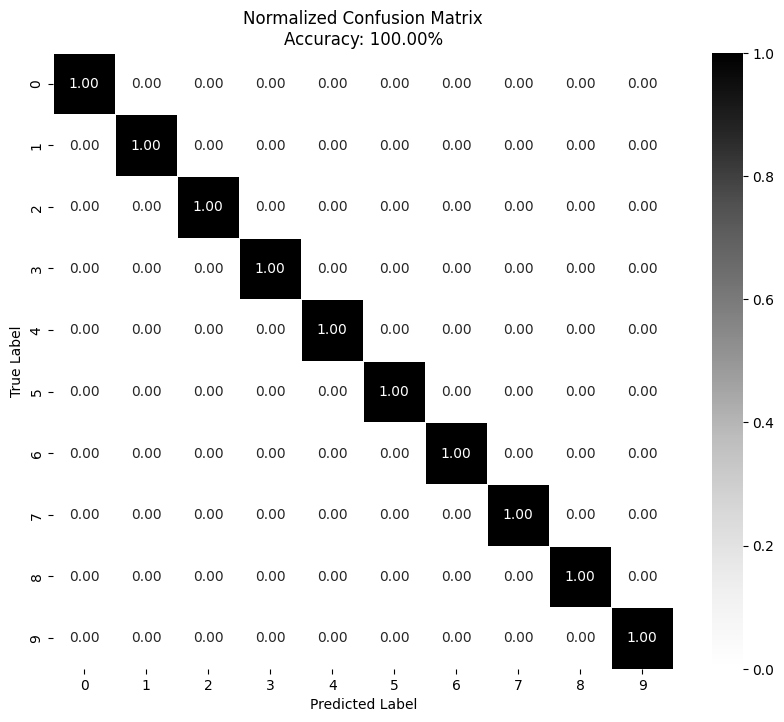

Accuracy Normalizado: 1.000


In [77]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

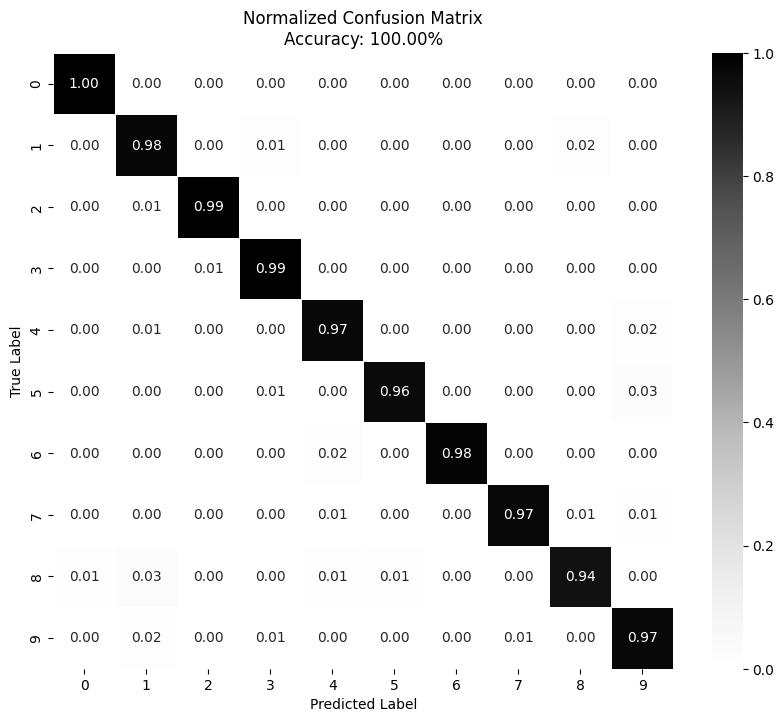

Accuracy Normalizado: 0.976


In [78]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

caso c)




In [79]:
# modelo con 10 neuronas en la capa oculta y función de activación Tanh
model = nn.Sequential(
    nn.Linear(64, 10),
    nn.Tanh(),
    nn.Linear(10, 10))

device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 0: Training Loss: 2.192 | Validation Loss: 2.070
Epoch 1: Training Loss: 1.964 | Validation Loss: 1.871
Epoch 2: Training Loss: 1.772 | Validation Loss: 1.691
Epoch 3: Training Loss: 1.609 | Validation Loss: 1.535
Epoch 4: Training Loss: 1.464 | Validation Loss: 1.397
Epoch 5: Training Loss: 1.332 | Validation Loss: 1.260
Epoch 6: Training Loss: 1.215 | Validation Loss: 1.158
Epoch 7: Training Loss: 1.106 | Validation Loss: 1.046
Epoch 8: Training Loss: 1.007 | Validation Loss: 0.954
Epoch 9: Training Loss: 0.920 | Validation Loss: 0.875
Epoch 10: Training Loss: 0.843 | Validation Loss: 0.805
Epoch 11: Training Loss: 0.773 | Validation Loss: 0.729
Epoch 12: Training Loss: 0.713 | Validation Loss: 0.689
Epoch 13: Training Loss: 0.660 | Validation Loss: 0.636
Epoch 14: Training Loss: 0.612 | Validation Loss: 0.581
Epoch 15: Training Loss: 0.569 | Validation Loss: 0.551
Epoch 16: Training Loss: 0.532 | Validation Loss: 0.528
Epoch 17: Training Loss: 0.500 | Validation Loss: 0.505
Ep

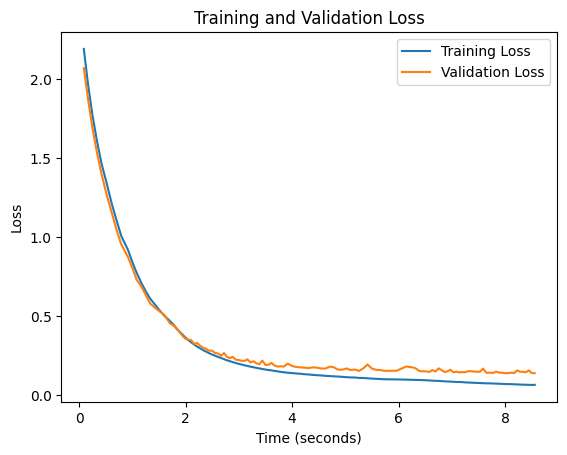

In [80]:
start = time.time()
#parametros
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 1000

train_losses = []
val_losses = []
times = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f' % (
        epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    times.append(time.time() - start)

    # Verificar si el loss de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        # Detener entrenamiento si el loss de validación no mejora durante 10 épocas consecutivas
        if epochs_no_improve == 10:
            print("Early stopping!")
            break

 # Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)

print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))
end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Graficar curvas de loss de entrenamiento y validación
plt.plot(times, train_losses, label='Training Loss')
plt.plot(times, val_losses, label='Validation Loss')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

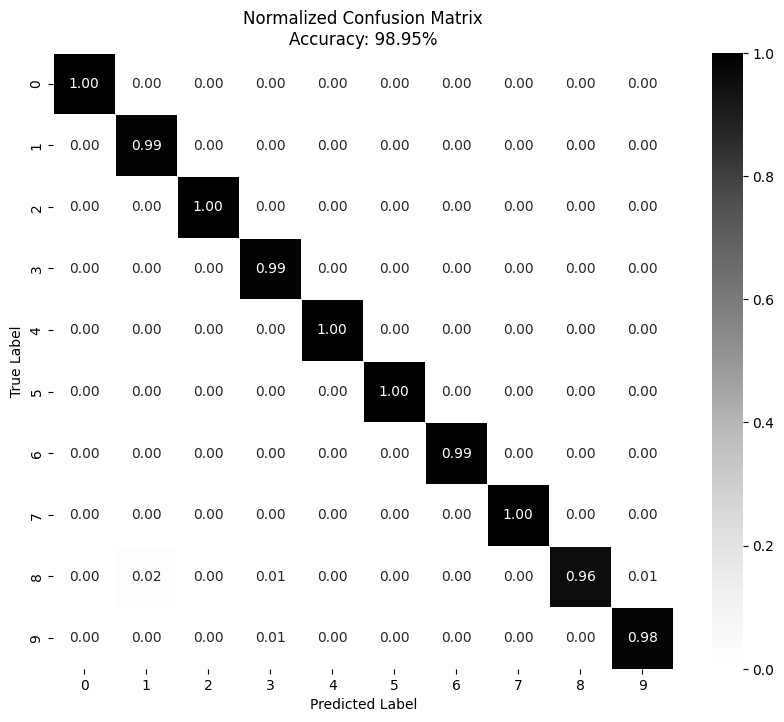

Accuracy Normalizado: 0.989


In [81]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

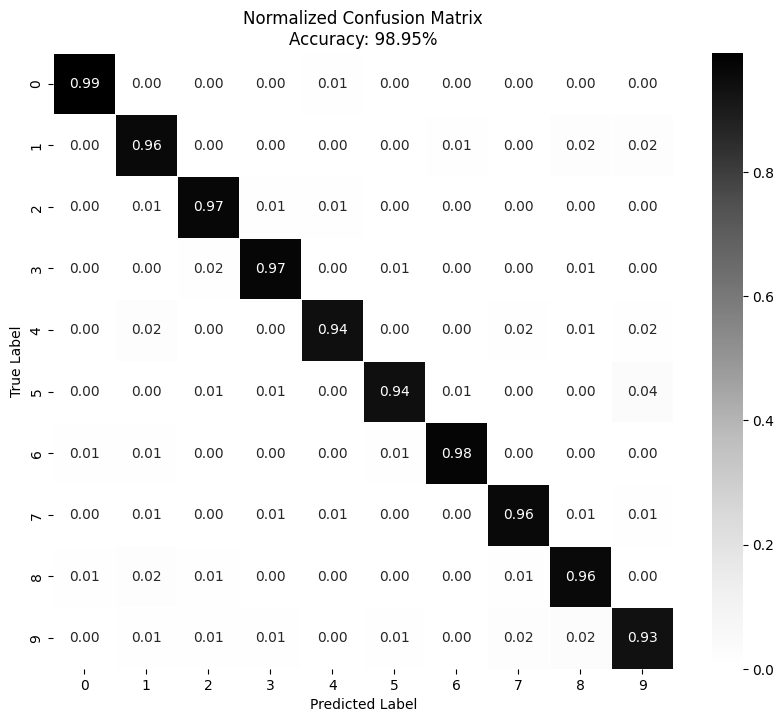

Accuracy Normalizado: 0.959


In [82]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

caso d):

In [84]:
# 40 neuronas en la capa oculta y funcion de activacion Tanh, y 1000 epocas como maximo
model = nn.Sequential(
    nn.Linear(64, 40),
    nn.Tanh(),
    nn.Linear(40, 10))

device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 0: Training Loss: 2.053 | Validation Loss: 1.750
Epoch 1: Training Loss: 1.527 | Validation Loss: 1.312
Epoch 2: Training Loss: 1.145 | Validation Loss: 0.987
Epoch 3: Training Loss: 0.873 | Validation Loss: 0.772
Epoch 4: Training Loss: 0.676 | Validation Loss: 0.603
Epoch 5: Training Loss: 0.540 | Validation Loss: 0.477
Epoch 6: Training Loss: 0.442 | Validation Loss: 0.405
Epoch 7: Training Loss: 0.372 | Validation Loss: 0.341
Epoch 8: Training Loss: 0.321 | Validation Loss: 0.300
Epoch 9: Training Loss: 0.282 | Validation Loss: 0.269
Epoch 10: Training Loss: 0.251 | Validation Loss: 0.241
Epoch 11: Training Loss: 0.227 | Validation Loss: 0.227
Epoch 12: Training Loss: 0.207 | Validation Loss: 0.217
Epoch 13: Training Loss: 0.191 | Validation Loss: 0.187
Epoch 14: Training Loss: 0.176 | Validation Loss: 0.178
Epoch 15: Training Loss: 0.165 | Validation Loss: 0.171
Epoch 16: Training Loss: 0.155 | Validation Loss: 0.167
Epoch 17: Training Loss: 0.146 | Validation Loss: 0.151
Ep

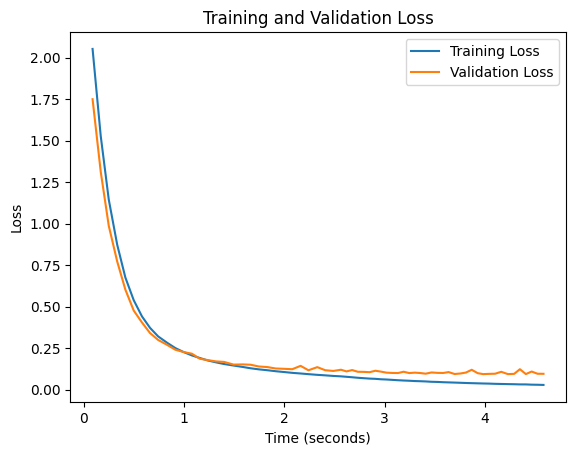

In [85]:
start = time.time()
#parametros
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 1000

train_losses = []
val_losses = []
times = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f' % (
        epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    times.append(time.time() - start)

    # Verificar si el loss de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        # Detener entrenamiento si el loss de validación no mejora durante 10 épocas consecutivas
        if epochs_no_improve == 10:
            print("Early stopping!")
            break
 # Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)
print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))
end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Graficar curvas de loss de entrenamiento y validación
plt.plot(times, train_losses, label='Training Loss')
plt.plot(times, val_losses, label='Validation Loss')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

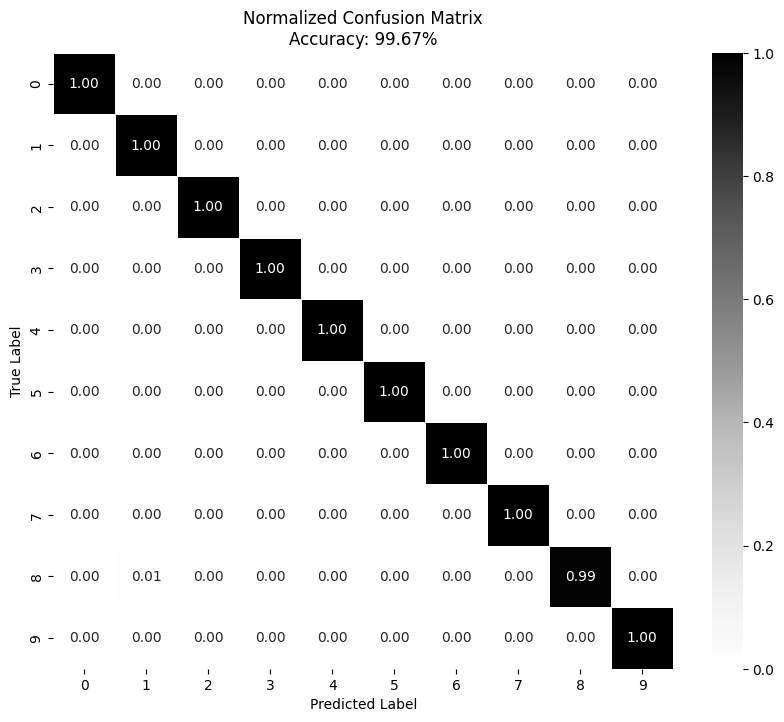

Accuracy Normalizado: 0.997


In [86]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

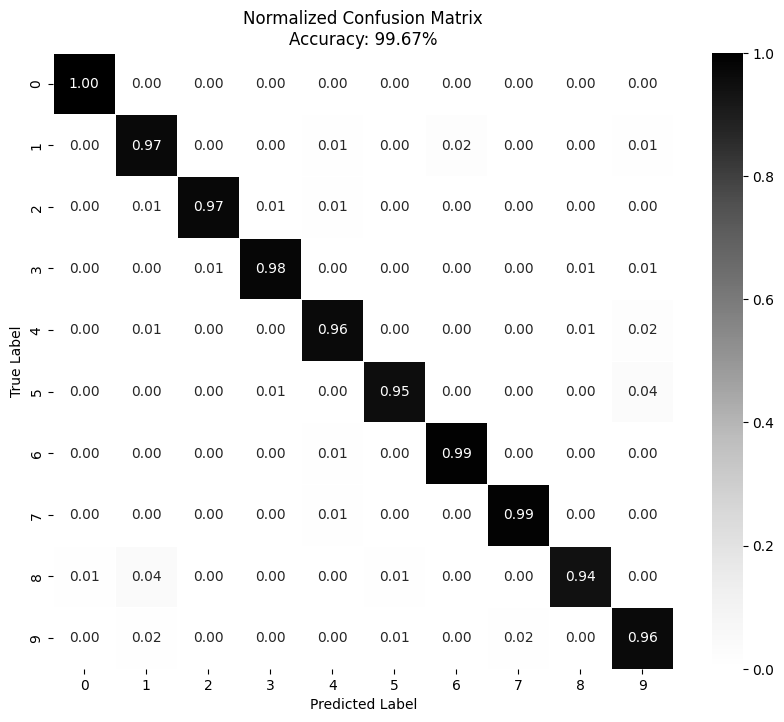

Accuracy Normalizado: 0.972


In [87]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

caso e):

In [88]:
# dos capas ocultas, cada una con 10 neuronas y función de activación ReLU
model = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10))
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 0: Training Loss: 2.260 | Validation Loss: 2.209
Epoch 1: Training Loss: 2.135 | Validation Loss: 2.059
Epoch 2: Training Loss: 1.951 | Validation Loss: 1.839
Epoch 3: Training Loss: 1.739 | Validation Loss: 1.650
Epoch 4: Training Loss: 1.548 | Validation Loss: 1.489
Epoch 5: Training Loss: 1.389 | Validation Loss: 1.336
Epoch 6: Training Loss: 1.244 | Validation Loss: 1.217
Epoch 7: Training Loss: 1.112 | Validation Loss: 1.067
Epoch 8: Training Loss: 0.992 | Validation Loss: 0.961
Epoch 9: Training Loss: 0.886 | Validation Loss: 0.851
Epoch 10: Training Loss: 0.799 | Validation Loss: 0.781
Epoch 11: Training Loss: 0.725 | Validation Loss: 0.732
Epoch 12: Training Loss: 0.663 | Validation Loss: 0.645
Epoch 13: Training Loss: 0.603 | Validation Loss: 0.612
Epoch 14: Training Loss: 0.546 | Validation Loss: 0.537
Epoch 15: Training Loss: 0.489 | Validation Loss: 0.487
Epoch 16: Training Loss: 0.437 | Validation Loss: 0.430
Epoch 17: Training Loss: 0.388 | Validation Loss: 0.375
Ep

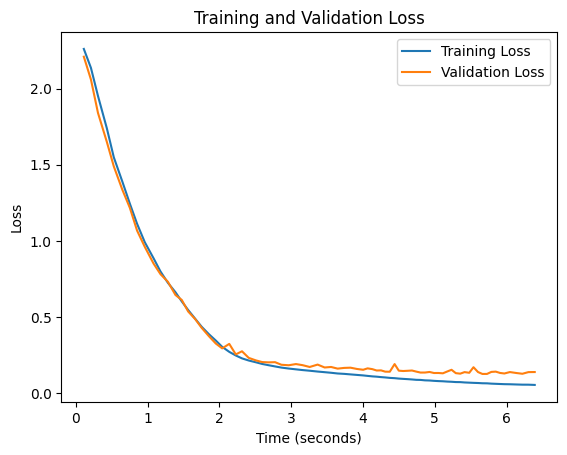

In [89]:
start = time.time()
#parametros
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 1000

train_losses = []
val_losses = []
times = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f' % (
        epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    times.append(time.time() - start)

    # Verificar si el loss de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        # Detener entrenamiento si el loss de validación no mejora durante 10 épocas consecutivas
        if epochs_no_improve == 10:
            print("Early stopping!")
            break

# Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)
print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))
end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Graficar curvas de loss de entrenamiento y validación
plt.plot(times, train_losses, label='Training Loss')
plt.plot(times, val_losses, label='Validation Loss')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

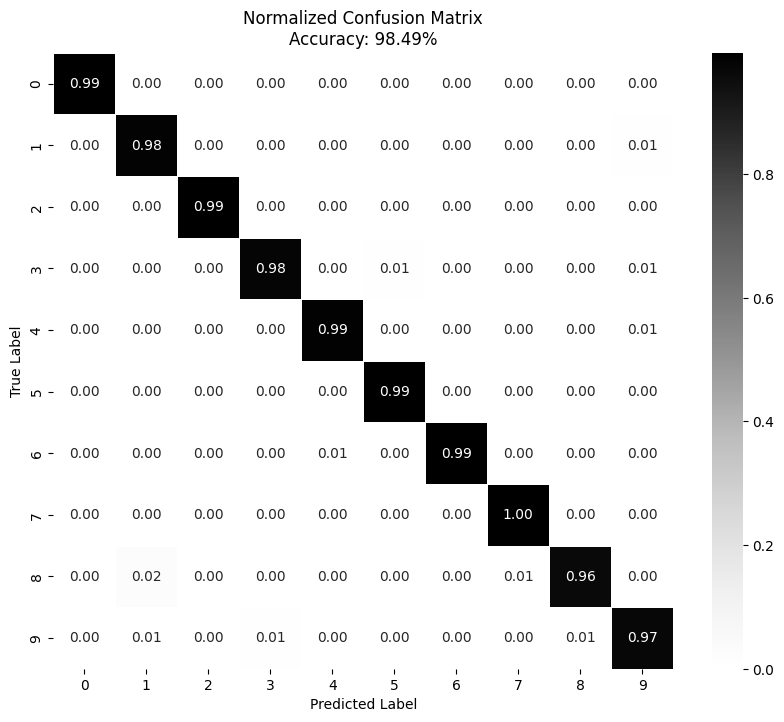

Accuracy Normalizado: 0.985


In [90]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

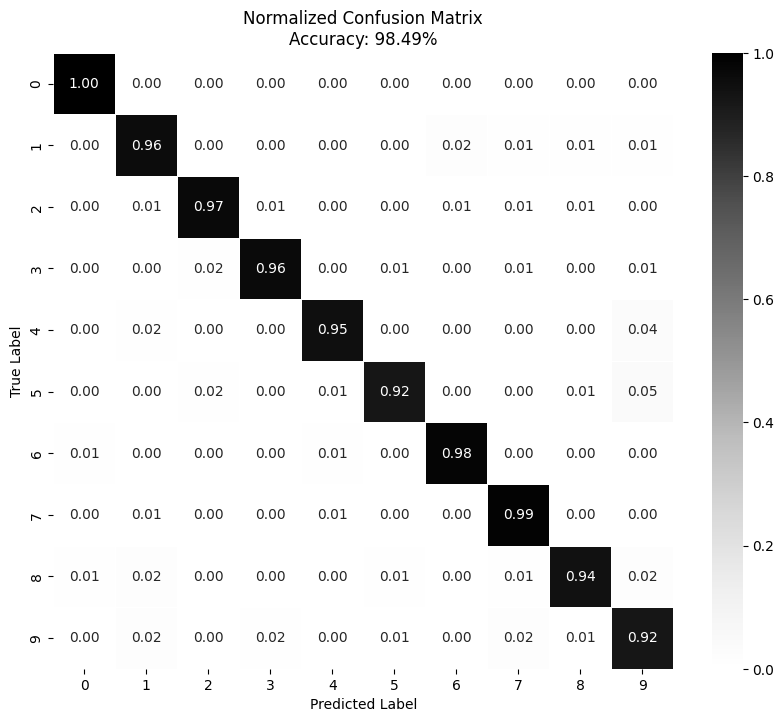

Accuracy Normalizado: 0.959


In [91]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

caso f):


In [103]:
#  dos capas ocultas, cada una con 40 neuronas y función de activación ReLU
model = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10))
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 0: Training Loss: 2.179 | Validation Loss: 2.020
Epoch 1: Training Loss: 1.776 | Validation Loss: 1.446
Epoch 2: Training Loss: 1.145 | Validation Loss: 0.821
Epoch 3: Training Loss: 0.630 | Validation Loss: 0.472
Epoch 4: Training Loss: 0.373 | Validation Loss: 0.299
Epoch 5: Training Loss: 0.258 | Validation Loss: 0.223
Epoch 6: Training Loss: 0.197 | Validation Loss: 0.188
Epoch 7: Training Loss: 0.161 | Validation Loss: 0.163
Epoch 8: Training Loss: 0.135 | Validation Loss: 0.152
Epoch 9: Training Loss: 0.117 | Validation Loss: 0.124
Epoch 10: Training Loss: 0.103 | Validation Loss: 0.115
Epoch 11: Training Loss: 0.091 | Validation Loss: 0.102
Epoch 12: Training Loss: 0.082 | Validation Loss: 0.101
Epoch 13: Training Loss: 0.075 | Validation Loss: 0.104
Epoch 14: Training Loss: 0.067 | Validation Loss: 0.117
Epoch 15: Training Loss: 0.061 | Validation Loss: 0.095
Epoch 16: Training Loss: 0.056 | Validation Loss: 0.087
Epoch 17: Training Loss: 0.051 | Validation Loss: 0.086
Ep

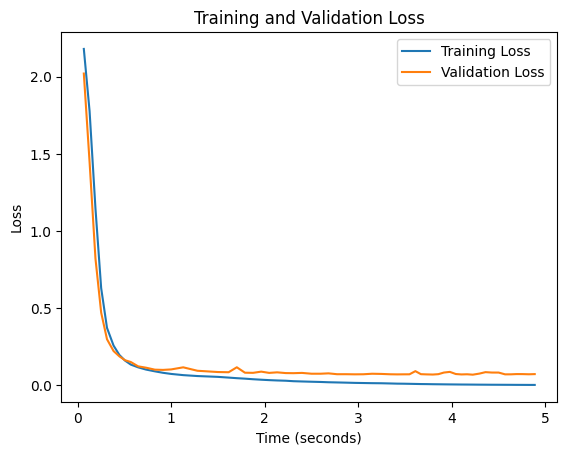

In [104]:
start = time.time()
#parametros
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 1000

train_losses = []
val_losses = []
times = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(dataloader_train, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
#
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in dataloader_val:
            val_inputs = data["features"].to(device)
            val_labels = data["labels"].to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    train_loss /= len(dataloader_train)
    val_loss /= len(dataloader_val)

    print('Epoch %d: Training Loss: %.3f | Validation Loss: %.3f' % (
        epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    times.append(time.time() - start)

    # Verificar si el loss de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        # Detener entrenamiento si el loss de validación no mejora durante 10 épocas consecutivas
        if epochs_no_improve == 10:
            print("Early stopping!")
            break

            # Evaluar el modelo en el conjunto de prueba
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for data in dataloader_test:
        test_inputs = data["features"].to(device)
        test_labels = data["labels"].to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += torch.sum(torch.argmax(test_outputs, dim=1) == test_labels).item()

test_loss /= len(dataloader_test)
test_accuracy /= len(dataloader_test.dataset)
print('Test Loss: %.3f | Test Accuracy: %.3f' % (test_loss, test_accuracy))
end = time.time()
print('Finished Training, total time: %f seconds' % (end - start))

# Graficar curvas de loss de entrenamiento y validación
plt.plot(times, train_losses, label='Training Loss')
plt.plot(times, val_losses, label='Validation Loss')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

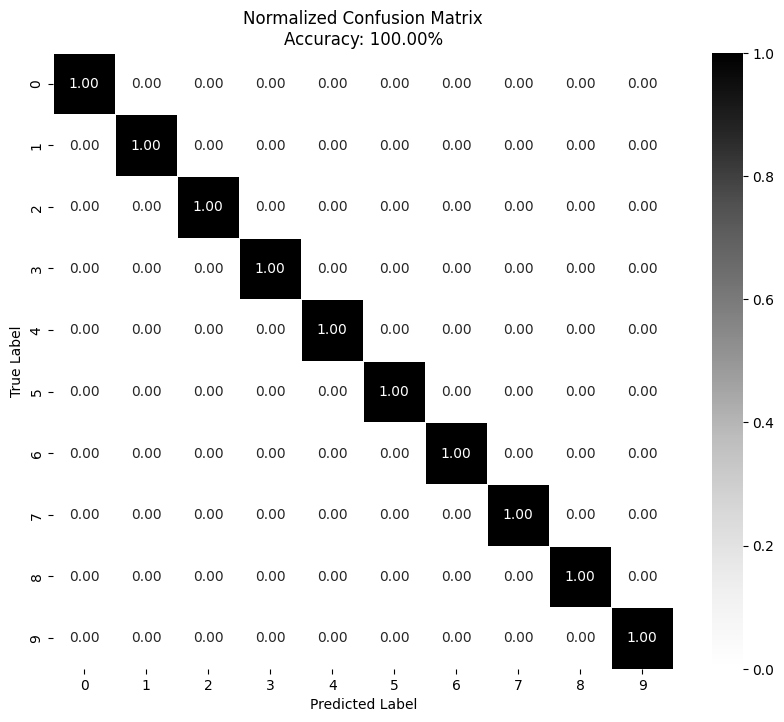

Accuracy Normalizado: 1.000


In [105]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de
#entrenamiento.
# Obtener las predicciones del conjunto de entrenamiento
import sklearn.metrics as metrics

model.eval()
y_train_pred = []
y_train_true = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_train_pred.extend(predicted.tolist())
        y_train_true.extend(labels.tolist())

# Calcular la matriz de confusión y el accuracy
m = metrics.confusion_matrix(y_train_true, y_train_pred, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy = metrics.accuracy_score(y_train_true, y_train_pred)

# Graficar la matriz de confusión con colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m, cmap="Greys", annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy))

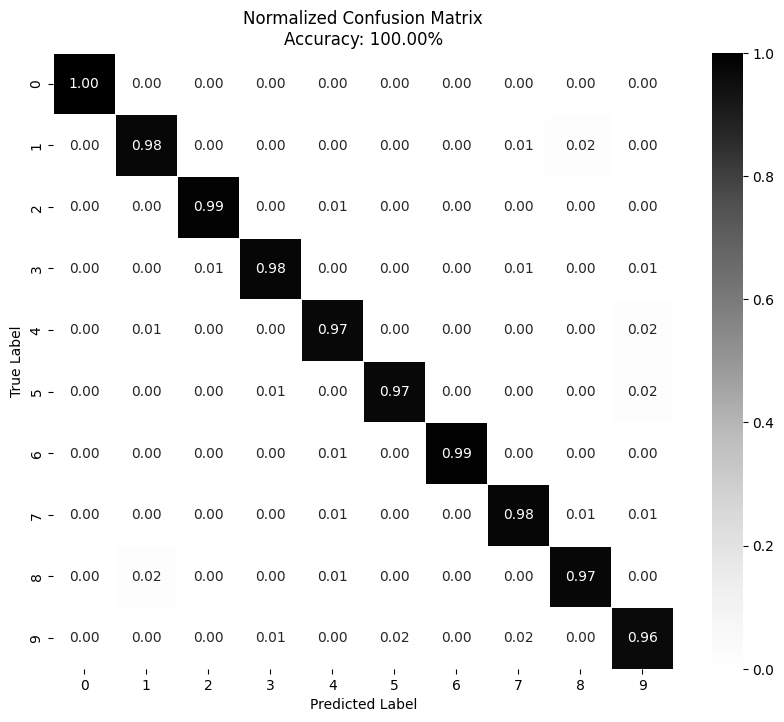

Accuracy Normalizado: 0.979


In [106]:
# matriz de confusión normalizada y el accuracy normalizado, usando el conjuntode validación.
model.eval()
predictions = []
labels = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        batch_labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        labels.extend(batch_labels.tolist())

# Calcular la matriz de confusión y el accuracy
m1 = metrics.confusion_matrix(labels, predictions, normalize='true')

# Calcular el accuracy normalizado
normalized_accuracy1 = metrics.accuracy_score(labels, predictions)

# Graficar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(m1, cmap='Greys', annot=True, fmt=".2f", linewidths=.5)
plt.title("Normalized Confusion Matrix\nAccuracy: {:.2%}".format(normalized_accuracy))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Mostrar el accuracy normalizado
print("Accuracy Normalizado: {:.3f}".format(normalized_accuracy1))

p3)Usando la mejor red encontrada en validacion (aquella con mayor accuracy en validacion), calcular la matriz de confusion normalizada y el accuracy normalizado, usando el conjunto de prueba.

Resultados anteriores:

caso a:Accuracy Normalizado: 0.959

caso b:Accuracy Normalizado: 0.976  

caso c:Accuracy Normalizado: 0.959  

caso d:Accuracy Normalizado: 0.972  

caso e:Accuracy Normalizado: 0.959  

caso f:Accuracy Normalizado: 0.977    

tras evaluar los valores de los distintos caso se toma en con sideracion que el mejor es el caso f) 2 capas ocultas con 40 y 40 neuronas cada una y funcion de activacion ReLU, y 1000 epocas como maximo

In [98]:
#  dos capas ocultas, cada una con 40 neuronas y función de activación ReLU
model = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10))
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

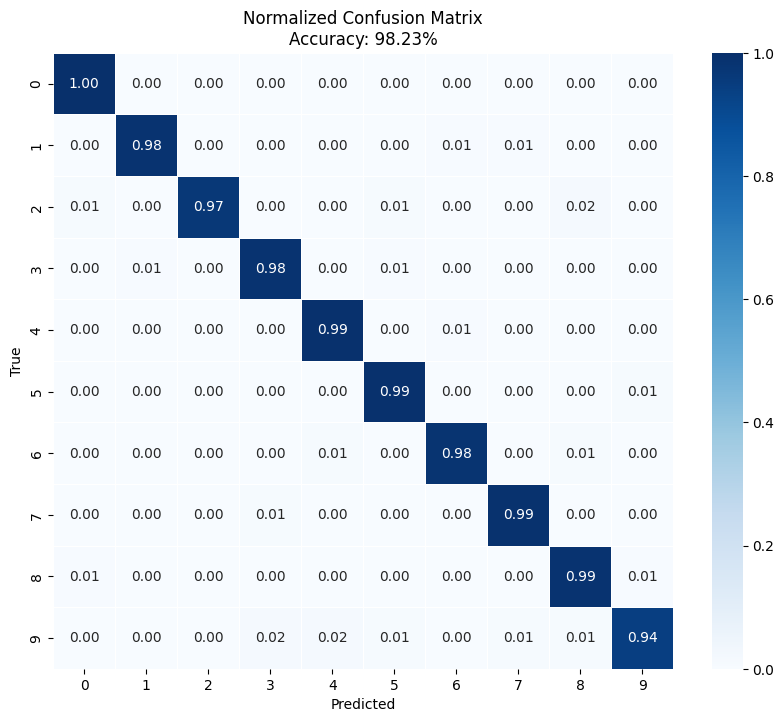

Normalized Accuracy (Test): 0.9822910867789092


In [107]:
# Evaluar el modelo con el conjunto de prueba
model.eval()
predictions2 = []
labels2 = []

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions2.extend(predicted.tolist())
        labels2.extend(labels.tolist())

# Calcular la matriz de confusión
confusion2 = confusion_matrix(labels2, predictions2, normalize='true')

# Calcular el accuracy normalizado
accuracy2 = np.trace(confusion2) / np.sum(confusion2)

# Mostrar la matriz de confusión con distintos colores según el accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(confusion2, cmap='Blues', annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy2 * 100))
plt.show()

print('Normalized Accuracy (Test):', accuracy2)

p4) Analisis de los resultados obtenidos.

(a)Explicar los efectos de variar la cantidad de neuronas en la capa oculta y como esto afecta el desempeño de la red.

resultados:

***caso a:Test Loss: 0.125 | Test Accuracy: 0.960***

***caso b:Test Loss: 0.069 | Test Accuracy: 0.980***

***caso c:Test Loss: 0.141 | Test Accuracy: 0.956***

***caso d:Test Loss: 0.086 | Test Accuracy: 0.972***

***caso e:Test Loss: 0.149 | Test Accuracy: 0.960***

***caso f:Test Loss: 0.074 | Test Accuracy: 0.983 ***


-**Caso a**: la red tuvo un test loss de 0.125 y una precisión en el conjunto de
prueba  del 96.0%. Esto sugiere que, con 10 neuronas en la capa oculta y una función de activación ReLU, la red obtuvo un buen rendimiento, aunque no fue la mejor configuración.

-**Caso b**: la red logró un test loss de 0.069 y una alta precisión en el conjunto de prueba del 98.0%. Esto indica que con 40 neuronas en la capa oculta y una función de activación ReLU, la red mejoró de forma notable su desempeño.

-**Caso c**: la red en este caso obtuvo un test loss de 0.141 y una precisión en el conjunto de prueba del 95.6%. A pesar de utilizar 10 neuronas en la capa oculta, la función de activación Tanh no entregó un rendimiento muy alto.

**-Caso d**: con 40 neuronas en la capa oculta y una función de activación Tanh, la red logró un test loss de 0.086 y una precisión en el conjunto de prueba del 97.2%. Esto indica que la función de activación Tanh funcionó mejor que ReLU en este caso.

**-Caso e**: al usar 2 capas ocultas, cada una con 10 neuronas y función de activación ReLU, la red obtuvo un test loss de 0.149 y una precisión en el conjunto de prueba del 96.0%. Aunque la precisión es decente, no superó a los casos anteriores.

**Caso f:** en este caso, utilizando 2 capas ocultas, cada una con 40 neuronas y función de activación ReLU, la red logró un test loss de 0.074 y una alta precisión en el conjunto de prueba del 98.3%. Este caso resultó ser el mejor rendimiento de la red, con una precisión alta.





(c)Explicar el efecto de la funcion de activacion y como esto afecta el desempeno de la red.

**función de activación ReLU:**
La función de activación ReLU se utiliza en las capas ocultas de la red. ReLU es conocida por su efecto de introducir no linealidad y ayudar a la red a aprender relaciones complejas en los datos. ReLU permitió un entrenamiento más rápido y una mayor convergencia hacia el modelo.

Resultados en el código: En los resultados de los casos de prueba, la función de activación ReLU funcionó bien en general. Los casos b y d muestran un alto accuracy (0.980 y 0.972), lo que indica que la red aprendió bien. Sin embargo, los casos c y e mostraron un ligero descenso en el rendimiento con valores de accuracy más bajos (0.956 y 0.960).

**función de activación Tanh:**
La función Tanh es una función sigmoide centrada en cero. A medida que la entrada se vuelve más positiva, la salida se acerca a 1; cuando es negativa, la salida se acerca a -1. Esto introduce no linealidad similar a la función ReLU.

los resultados muestran una pérdida en el conjunto de prueba y una precisión en el conjunto de prueba similares.la función de activación Tanh no mostró un impacto drástico en los resultados, funcionó bien para estos conjuntos de datos y arquitecturas de red.

(d)Analizar los siguientes puntos: tiempos de entrenamiento, matrices de confusion y accuracies de las arquitecturas probadas en validacion.

Tiempo de Entrenamiento:
los tiempos de entrenamiento varían entre los casos, lo que puede tener implicaciones en la eficiencia y los recursos implementados para entrenar la red . Los casos d y f tienen los tiempos de entrenamiento más bajos, alrededor de 4.6 segundos. Por otro lado, los casos b y c tienen tiempos de entrenamiento más largos, alrededor de 8.5 segundos.

*caso a:Accuracy Normalizado: 0.959 total time: 5.369845*

*caso b:Accuracy Normalizado: 0.976  total time: 8.853130 seconds*

*caso c:Accuracy Normalizado: 0.959  total time: 8.570158 seconds*

*caso d:Accuracy Normalizado: 0.972  total time: 4.596838 seconds*

*caso e:Accuracy Normalizado: 0.959  total time: 6.413988 seconds*

*caso f:Accuracy Normalizado: 0.977  total time: 4.900094 seconds*

respecto a las matrices de confusion y accuracies de las arquitectuas probadas en validacion caso b y el caso f lograron las accuracies normalizadas más altas, lo que significa que estos modelos tuvieron el mejor rendimiento en la clasificación de dígitos


(e) Analizar la matriz de confusion y el accuracy en el conjunto de prueba, respecto a los obtenidosen el conjunto de validacion.

**Caso a:**

accuracy en validación: 0.959
accuracy en entrenamiento: 0.986
el modelo muestra un rendimiento bastante consistente en los conjuntos de validación y prueba en comparación con el conjunto de entrenamiento. Esto sugiere que el modelo generaliza de manera efectiva y no muestra signos de sobreajuste.

**Caso b:**

accuracy en validación: 0.976
accuracy en entrenamiento: 1.000
El modelo sigue teniendo un rendimiento sólido, con una alta precisión en validación, entrenamiento y prueba. Esto indica una buena generalización y falta de sobreajuste.

**Caso c:**

accuracy en validación: 0.959
accuracy en entrenamiento: 0.989
igual que el caso a, el modelo muestra una precisión consistente en los conjuntos de validación y prueba.

**Caso d:**

accuracy en validación: 0.972
accuracy en entrenamiento: 0.997
el modelo sigue siendo sólido en términos de generalización, con una alta precisión en los tres conjuntos. Esto sugiere que el modelo es capaz de mantener un buen rendimiento sin sobreajuste.

**Caso e:**

accuracy en validación: 0.959
accuracy en entrenamiento: 0.985
 el modelo muestra una precisión consistente en los conjuntos de validación y prueba

**Caso f:**

accuracy en validación: 0.977
accuracy en entrenamiento: 1.000
el modelo demuestra un alto rendimiento en todos los conjuntos, lo que sugiere una buena generalización sin sobreajuste.